# **1. Overview**
This Jupyter notebook covers various steps of implementing CNN architecture in order to build image classification model that detects Covid-19 from x-ray images.

Following code section import all the important Python modules required for this exercise.

In [2]:
import os
import zipfile
import copy
import random
import numpy as np
import torch
import time
import torchsummary
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# **2. Load data from external source**



1.   Download the dataset from external datasource: https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia)
2.   Upload the dataset in zip format to google drive and mount the drive in Colab environment
1.   Copy the zip file from mount drive to Colab folder
2.   Unzip the file
1.   Set the data path to unzipped file location








In [2]:
!cp '/content/drive/MyDrive/chest-xray-data/Data.zip' '/content'
local_zip = '/content/Data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()
DATA_PATH = "Data"

In [3]:
DATA_PATH = "Data"

# **3. Image count statistics**

Dataset contains 6432 images of seggreated into three different types - 

1. Normal\Healthy person x-ray image, 2. Pneumonia patient x-ray image, 3. Covid-19 patient x-ray image

In [4]:
def get_count_metrics(folder, data_path=DATA_PATH):

    train_dir = os.path.join(data_path, folder)
    list_p = os.listdir(os.path.join(train_dir,'PNEUMONIA')) # dir is your directory path
    num_p = len(list_p)
    list_n = os.listdir(os.path.join(train_dir,'NORMAL')) # dir is your directory path
    num_n = len(list_n)
    list_c = os.listdir(os.path.join(train_dir,'COVID19')) # dir is your directory path
    num_c = len(list_c)
    count_tuple = (int(num_n), int(num_p), int(num_c))
    
    return count_tuple

print(get_count_metrics('train'))
print(get_count_metrics('test'))


(1266, 3418, 460)
(317, 855, 116)


# **4. Image augmentation and load data**

Use python's transform module to perform following image augmentation steps:

1.   Resize the x-ray image to the image of shape(256, 256) uniformly
2.   Apply centercrop function to crop the center part of the image of shape (224, 224)
1.   Convert image to tensor
2.   Load train and test data using ImageFolder function
5.   Concatenate the train and test dataset




In [5]:
def load_data(data_path=DATA_PATH):

    # your code here
    transform_dict = {
        'train': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
         ]),
        'test': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
         ])}
    
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['train'])
    print(train_data.class_to_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
    #print(train_loader.class_to_idx)
    print('train_loader - len', len(train_data))
    print('train_loader - type', type(train_data))
    
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['test'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
    print('test_loader - len', len(test_data))
    print('test_loader - type', type(test_data))
    #raise NotImplementedError
    
    return train_data, test_data, train_loader, test_loader

train_data, test_data, train_loader1, test_loader1 = load_data()

dataset = torch.utils.data.ConcatDataset([train_data, test_data])

print(len(dataset))

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
train_loader - len 5144
train_loader - type <class 'torchvision.datasets.folder.ImageFolder'>
test_loader - len 1288
test_loader - type <class 'torchvision.datasets.folder.ImageFolder'>
6432


# **6. GPU**

Enable GPU capacity for model building exercise 

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

cuda:0
Using CUDA


# **7. Visualization**

Visulaize a batch of images representing train dataset

Sample images for training purpose:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 2, 1, 2, 2, 0, 1, 2])


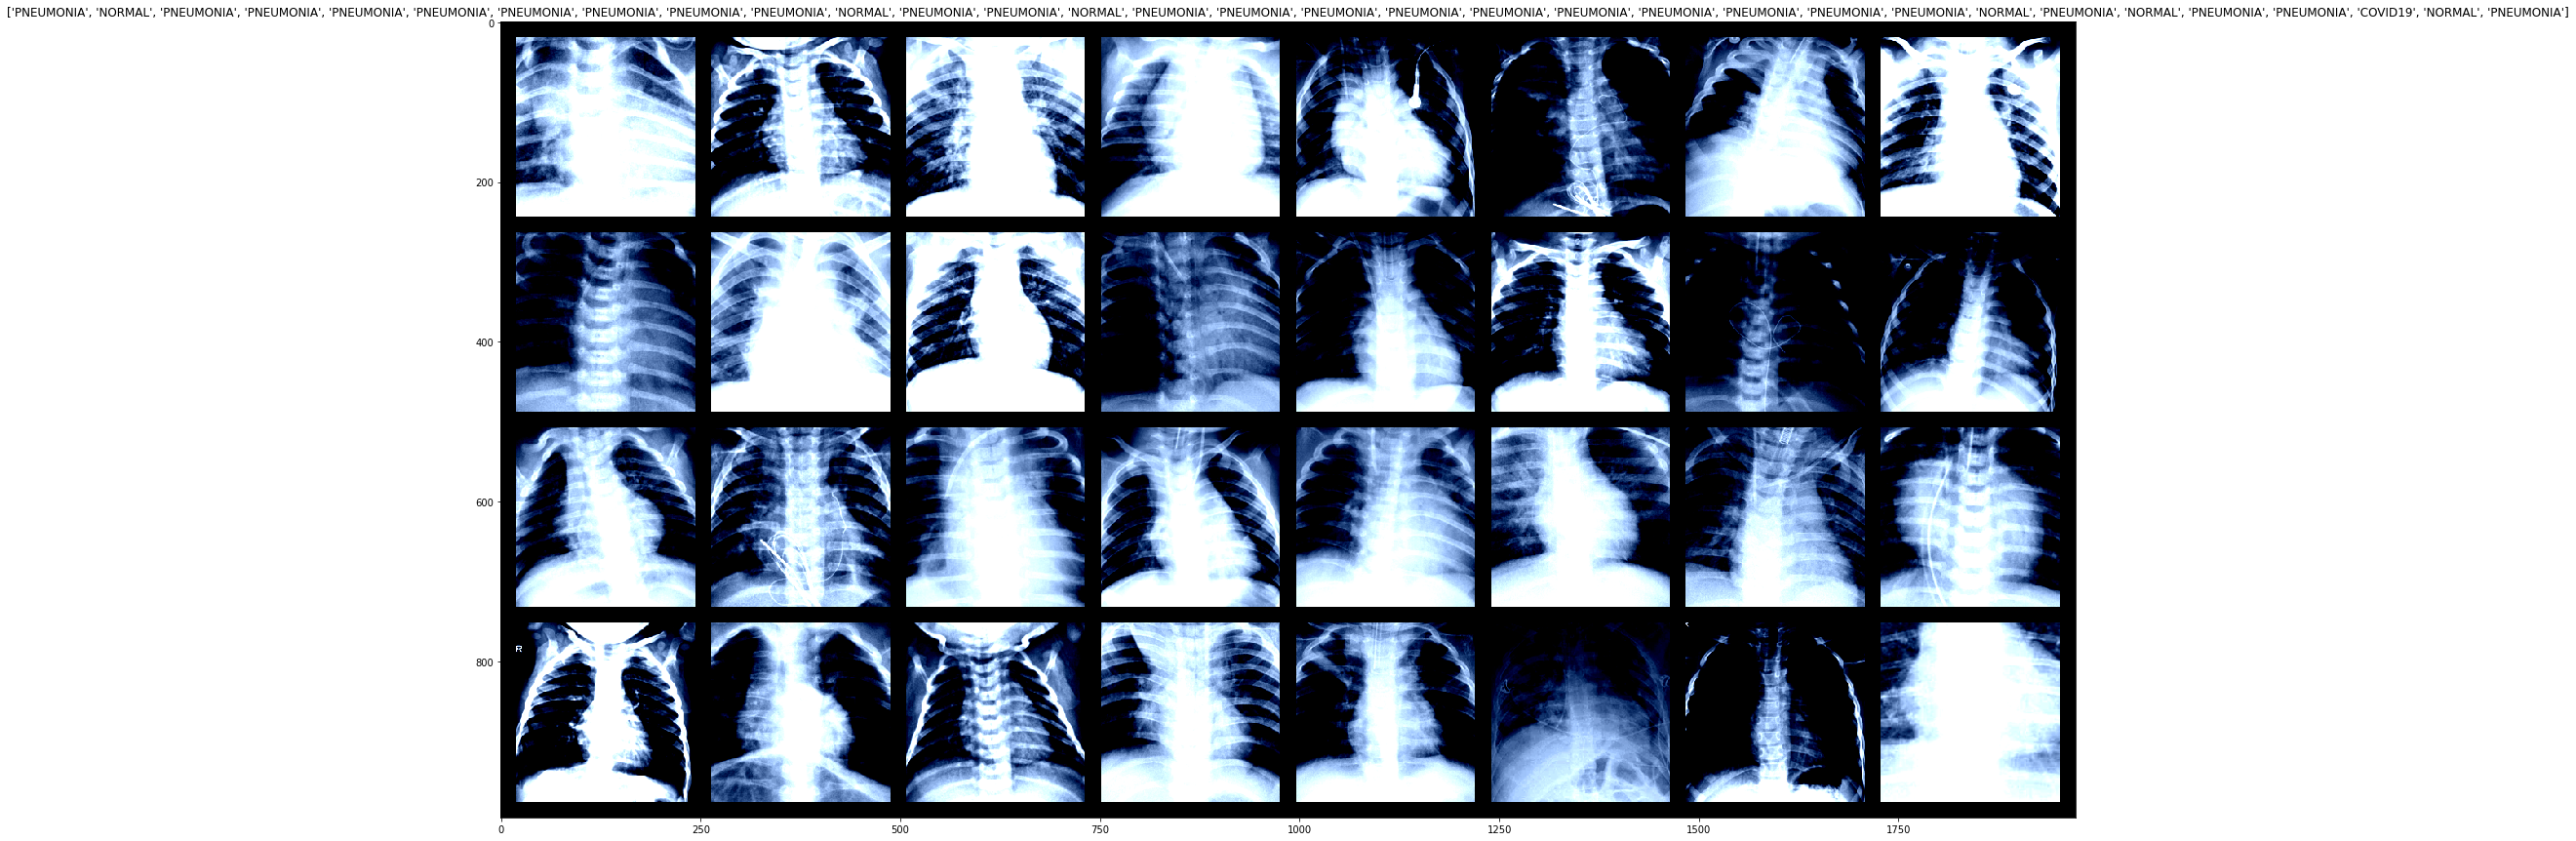

In [7]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, padding=20)
    print(labels)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(30, 15))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.title(label=["COVID19" if x==0  else ("NORMAL" if x == 1 else "PNEUMONIA") for x in labels])
    plt.show()

print(f'Sample images for training purpose:')
for i in range(1):
    show_batch_images(train_loader1) 

# **8. Model Development**
# Load pre-trained model
For this image classification exercise, we leveraged following pre-trained models as a part of transfer learning approach:

1.   VGG16
2.   ResNet18
1.   ResNet50

All the models have been loaded from the torchvision module. (https://pytorch.org/vision/stable/models.html)


In [7]:
# Multi-class classification
num_classes = 3

#Vgg16 model

vgg16 = models.vgg16_bn(pretrained=True)

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 3 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

vgg16.cuda()

#ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
   
num_ftrs = resnet18.fc.in_features        
resnet18.fc = nn.Linear(num_ftrs, num_classes)

resnet18.cuda()

#ResNet18 model

resnet50 = torchvision.models.resnet50(pretrained=True)
# Freeze training for all layers
for param in resnet50.parameters():
    param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = resnet50.fc.in_features        
resnet50.fc = nn.Linear(num_ftrs, num_classes)

resnet50.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Build simple CNN architecture

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.linear1 = nn.Linear(14 * 14 * 32, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        pred = self.linear2(x)

        return pred

model = SimpleCNN()

model.cuda()

# **9. K-fold cross validation**

k-fold cross validation technique has been used to train and evaluate the model using provided data.


1.   Set k=5 to perform cross validation using 5 folds.
2.   Generate train and test data using random sampler for each fold.
1.   Perform forward propagation using pre-trained model 
2.   Calculate train loss and perform optimization with zero gradient
1.   Evaluation the model using test data
2.   Calculate accuracy measures such as AUC, precision, recall and F1-score.

Following section only shows the cross validation step for ResNet50 model. 





In [30]:
if __name__ == '__main__':
  
  # Configurat,ion options
  k_folds = 5
  num_epochs = 1
  loss_function = nn.CrossEntropyLoss()
  
  # For fold results
  results_AUC = {}
  results_precision = {}
  results_recall = {}
  results_f1 = {}
  
  # Set fixed random number seed
  torch.manual_seed(24)
  
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=4, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=test_subsampler)

    _START_RUNTIME = time.time()

    resnet50.train() # Prep model for training
    # Initialize optimizer
    optimizer = torch.optim.SGD(resnet50.parameters(), lr=1e-2, momentum=0.9)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
        print(f'Starting epoch {epoch+1}')

      # Set current loss value
        curr_epoch_loss = []
      # Iterate over the DataLoader for training data
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            targets = labels.to(device)
            #inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        
        # Zero the gradients
            optimizer.zero_grad()
        
        # Perform forward pass
            outputs = resnet50(inputs)
        
        # Compute loss
            loss = loss_function(outputs, targets)
        
        # Perform backward pass
            loss.backward()
        
        # Perform optimization
            optimizer.step()
        
        # Print statistics
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print("Total train time = {:.2f} seconds".format(time.time() - _START_RUNTIME))    
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
            
    # Process is complete.
        print('Training process has finished. Saving trained model.')

    # Print about testing
        print('Starting testing')
    
    # Saving the model
        save_path = f'./model-fold-{fold}.pth'
        torch.save(resnet50.state_dict(), save_path)

    # Evaluationfor this fold
        resnet50.eval()
      # Iterate over the test data and generate predictions
        Y_pred = []
        Y_test = []
        predictions, actuals = list(), list()
        for inputs, targets in train_loader:
            if use_gpu:
              inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        # Generate outputs
          #outputs = resnet50(inputs)

            Y_pred_orig = resnet50(inputs)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.cpu().detach().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1)

            Y_test = targets.cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1)

            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
        Y_pred = np.concatenate(predictions, axis=0)
        Y_test = np.concatenate(actuals, axis=0)

      # Print accuracy

        acc = accuracy_score(Y_test, Y_pred)
        results_AUC[fold] = round(acc, 2)
        precision = precision_score(Y_test, Y_pred, average="macro")
        results_precision[fold] = round(precision, 2)
        recall = recall_score(Y_test, Y_pred, average="macro")
        results_recall[fold] = round(recall, 2) 
        f1 = f1_score(Y_test, Y_pred, average="macro")
        results_f1[fold] = round(f1,2)

        print("AUC for fold %d: %s %% using ResNet50 model: " % (fold, str(acc)))
        print("Precision for fold %d: %s %% using ResNet50 model: " % (fold, str(precision))) 
        print("Recall for fold %d: %s %% using ResNet50 model: " % (fold, str(recall))) 
        print("F1-score for fold %d: %s %% using ResNet50 model: " % (fold, str(f1)))   

        print('--------------------------------')



--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Total train time = 62.87 seconds
Epoch 0: curr_epoch_loss=0.29390954971313477
Training process has finished. Saving trained model.
Starting testing
AUC for fold 0: 0.854421768707483 % using ResNet50 model: 
Precision for fold 0: 0.819423025028685 % using ResNet50 model: 
Recall for fold 0: 0.917962524211006 % using ResNet50 model: 
F1-score for fold 0: 0.8520214522613031 % using ResNet50 model: 
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Total train time = 62.52 seconds
Epoch 0: curr_epoch_loss=0.28617632389068604
Training process has finished. Saving trained model.
Starting testing
AUC for fold 1: 0.9481049562682216 % using ResNet50 model: 
Precision for fold 1: 0.9414805338486101 % using ResNet50 model: 
Recall for fold 1: 0.9485071586920788 % using ResNet50 model: 
F1-score for fold 1: 0.9446420613204182 % using ResNet50 model: 
-------------------

# **10. Final model accuracy result**

In [31]:
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print(f'AUC results:')
sum_AUC = 0.0
Max_AUC = 0.0
for key, value in results_AUC.items():
  print(f'Fold {key}: {value} %')
  sum_AUC = value
  if Max_AUC < sum_AUC:
    Max_AUC = sum_AUC
#print(f'Maximum AUC: {sum_AUC/len(results_AUC.items())} %')
print(f'Maximum AUC: {Max_AUC} %')

print(f'Precision results:')
sum_precision = 0.0
Max_precision = 0.0
for key, value in results_precision.items():
  print(f'Fold {key}: {value} %')
  sum_precision = value
  if Max_precision < sum_precision:
    Max_precision = sum_precision
#print(f'Average: {sum_precision/len(results_precision.items())} %')
print(f'Maximum precision: {Max_precision} %')

print(f'Recall results:')
sum_recall = 0.0
Max_recall = 0.0
for key, value in results_recall.items():
  print(f'Fold {key}: {value} %')
  sum_recall = value
  if Max_recall < sum_recall:
    Max_recall = sum_recall
#print(f'Average: {sum_recall/len(results_recall.items())} %')
print(f'Maximum recall: {Max_recall} %')

print(f'F1-score results:')
sum_f1 = 0.0
Max_f1 = 0.0
for key, value in results_f1.items():
  print(f'Fold {key}: {value} %')
  sum_f1 = value
  if Max_f1 < sum_f1:
    Max_f1 = sum_f1
#print(f'Average: {sum_f1/len(results_f1.items())} %')
print(f'Maximum f1-score: {Max_f1} %')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
AUC results:
Fold 0: 0.85 %
Fold 1: 0.95 %
Fold 2: 0.95 %
Fold 3: 0.95 %
Fold 4: 0.96 %
Maximum AUC: 0.96 %
Precision results:
Fold 0: 0.82 %
Fold 1: 0.94 %
Fold 2: 0.96 %
Fold 3: 0.96 %
Fold 4: 0.95 %
Maximum precision: 0.96 %
Recall results:
Fold 0: 0.92 %
Fold 1: 0.95 %
Fold 2: 0.93 %
Fold 3: 0.94 %
Fold 4: 0.96 %
Maximum recall: 0.96 %
F1-score results:
Fold 0: 0.85 %
Fold 1: 0.94 %
Fold 2: 0.94 %
Fold 3: 0.95 %
Fold 4: 0.95 %
Maximum f1-score: 0.95 %
